# Session 6 - Working with word embeddings

So far we've seen a couple of key Python libraries for doing specific tasks in NLP. For example, ```scikit-learn``` provides a whole host of fundamental machine learning algortithms; ```spaCy``` allows us to do robust linguistic analysis; ```pandas``` for working with dataframes; ```numpy``` for numerical calculations; and ```matplotlib``` for simple plotting.

Today, we're going to meet ```gensim``` which is the best way to work with (static) word embeddings like word2vec. You can find the documentation [here](https://radimrehurek.com/gensim/).

In [2]:
import gensim
import gensim.downloader
import gensim.downloader as api

import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

## Choose a language

I've downloaded a number of pretrained word2vec models for different languages. I've tried to get a model for every language spoken as a first language by at least one person in the class.

Feel free to experiment with a couple, but make sure to use different variable names for the models.

NB: The English embeddings are 300d; the Danish are 500d. Notice also that different word2vec models are loaded in different ways. This is due to way that they were saved after training - the saved formats are not consistently the same.

In [3]:
# Danish embeddings https://korpus.dsl.dk/resources/details/word2vec.html
#model = gensim.models.KeyedVectors.load_word2vec_format("danish_word2vec.bin", binary=True)

# English embeddings http://vectors.nlpl.eu/repository/ (English CoNLL17 corpus)
model = gensim.models.KeyedVectors.load("../../../cds-lang-data/word2vec_models/english/english_word2vec.bin")

# if UCloud doesn't work...
# model = api.load("glove-twitter-50")

I've outlined a couple of tasks for you below to experiment with. Use these just a stepping off points to explore the nature of word embeddings and how they work.

Work in small groups on these tasks and make sure to discuss the issues and compare results - preferably across languages!

### Task 1: Finding polysemy

Find a polysemous word (i.e. words with more than one meaning) such that the top-10 most similar words (according to cosine similarity) contains related words from both meanings. An example is given for you below in English. 

Are there certain words for which polysemy is more of a problem?

In [6]:
model.most_similar("find")

[('discover', 0.6813523769378662),
 ('finding', 0.6766965389251709),
 ('Finding', 0.6114464402198792),
 ('found', 0.6038725972175598),
 ('tofind', 0.588554322719574),
 ('fi_nd', 0.5773409605026245),
 ('locate', 0.5766041278839111),
 ('uncover', 0.5601666569709778),
 ('see', 0.5559592843055725),
 ('stumble_upon', 0.5460631847381592)]

### Task 2: Synonyms and antonyms

In the lecture, we saw that _cosine similarity_ can also be thought of as _cosine distance_, which is simply ```1 - cosine similarity```. So the higher the cosine distance, the further away two words are from each other and so they have less "in common".

Find three words ```(w1,w2,w3)``` where ```w1``` and ```w2``` are synonyms (same meaning) and ```w1``` and ```w3``` are antonyms (opposite meaning), but where: 

```Cosine Distance(w1,w3) < Cosine Distance(w1,w2)```

For example, if we look at the example below:

w1="happy" is closer to w3="sad" than to w2="cheerful".

Once you have found your example, think about a possible explanation for why this counter-intuitive result may have happened. Are there any inconsistencies?
- sad is used so much more frequently than cheerful that it weighs more than the distance from the semantic meanings

You should use the the ```model.distance(w1, w2)``` function here in order to compute the cosine distance between two words. I've given a starting example below.

In [7]:
model.distance("happy", "sad")

0.4645386338233948

In [8]:
model.distance("happy","cheerful")

0.6162261962890625

In [9]:
model.distance("happy", "sad") < model.distance("happy","cheerful")

True

### Task 3: Word analogies

We saw in the lecture on Wednesday that we can use basic arithmetic on word embeddings, in order to conduct word analogy task.

For example:

```man::king as woman::queen```

So we can say that if we take the vector for ```king``` and subtract the vector for ```man```, we're removing the gender component from the ```king```. If we then add ```woman``` to the resulting vector, we should be left with a vector similar to ```queen```.

NB: It might not be _exactly_ the vector for ```queen```, but it should at least be _close_ to it.

```gensim``` has some quirky syntax that allows us to perform this kind of arithmetic.

In [10]:
model.most_similar(positive=['king', 'woman'], 
                   negative=['man'])[0]

('queen', 0.7118193507194519)

Try to find at least three analogies which correctly hold - where "correctly" here means that the closest vector corresponds to the word that you as a native speaker think it should.

In [11]:
model.most_similar(positive=['dog', 'kitten'], 
                   negative=['puppy'])[0]

('cat', 0.7460470795631409)

In [19]:
model.most_similar(positive=['London', 'Sweden'], 
                   negative=['Britain'])[0]

('Stockholm', 0.72334885597229)

In [22]:
model.most_similar(positive=['ophthalmologist', 'ear'], 
                   negative=['eye'])[0]

('audiologist', 0.6055264472961426)

### Task 3b: Wrong analogies

Can you find any analogies which _should_ hold but don't? Why don't they work? Are there any similarities or trends?

In [17]:
model.most_similar(positive=['London', 'Denmark'], 
                   negative=['Britain'])[:10]

[('Stockholm', 0.5968585014343262),
 ('Lyngby', 0.5967260003089905),
 ('Hellerup', 0.59401935338974),
 ('Arhus', 0.5801472663879395),
 ('Vejle', 0.5706729888916016),
 ('Copenhagen', 0.5650193691253662),
 ('Holbaek', 0.5639907717704773),
 ('Gentofte', 0.5535225868225098),
 ('Århus', 0.5533591508865356),
 ('Amsterdam', 0.549577534198761)]

### Task 4: Exploring bias

As we spoke briefly about in the lecture, word embeddings tend to display bias of the kind found in the training data.

Using some of the techniques you've worked on above, can you find some clear instances of bias in the word embedding models that you're exploring

In [40]:
model.most_similar(positive=['blue', 'woman'], 
                   negative=['man'])

[('pink', 0.6573087573051453),
 ('purple', 0.6393612027168274),
 ('turquoise', 0.5996761918067932),
 ('red', 0.584793746471405),
 ('cobalt_blue', 0.5797168016433716),
 ('white', 0.5784903764724731),
 ('colored', 0.5774471759796143),
 ('cornflower_blue', 0.5646229386329651),
 ('pale_blue', 0.5573784708976746),
 ('teal', 0.5573394894599915)]

### Task 5: Dimensionality reduction and visualizing

In the following cell, I've written a short bit of code which takes a given subset of words and plots them on a simple scatter plot. Remember that the word embeddings are 300d (or 100d here, depending on which language you're using), so we need to perform some kind of dimensionality reduction on the embeddings to get them down to 2D.

Here, I'm using a simply PCA algorithm implemented via ```scikit-learn```. An alternative approach might also be to use Singular Value Decomposition or SVD, which works in a similar but ever-so-slightly different way to PCA. You can read more [here](https://jeremykun.com/2016/04/18/singular-value-decomposition-part-1-perspectives-on-linear-algebra/) and [here](https://jonathan-hui.medium.com/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491) - the maths is bit mind-bending, just FYI.

Experiment with plotting certain subsets of words by changing the ```words``` list. How useful do you find these plots? Do they show anything meaningful?


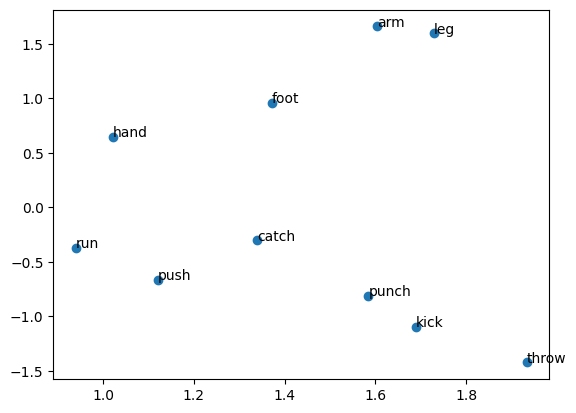

In [44]:
# the list of words we want to plot
words = ["arm", "throw", "push", "leg", "kick", "punch", "run", "hand", "foot", "catch"]

# an empty list for vectors
X = []
# get vectors for subset of words
for word in words:
    X.append(model[word])

# Use PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# or try SVD - how are they different?
svd = TruncatedSVD(n_components=2)
# fit_transform the initialized PCA model
result = svd.fit_transform(X)

# create a scatter plot of the projection
plt.scatter(result[:, 0], result[:, 1])

# for each word in the list of words
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

plt.show()

### Bonus tasks

If you run out of things to explore with these embeddings, try some of the following tasks:

[Easier]
- Using what you know about ```matplotlib``` make new plots like those above but cleaner and more informative
- Write a ```.py``` script which takes the visualization code above which can be run from the command line directly

[Harder]
- Word embeddings are numerical vectors for individual tokens. Can you think about how you would create a document-level embedding for, say, a full sentence?
    - Try to implement a crude method of creating a sentence embedding from word embeddings in that sentence.


In [55]:
from session6 import languagemodel
words = ["woman", "man"]
languagemodel(words)

TypeError: languagemodel() takes 0 positional arguments but 1 was given